In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
def readInputData(fileName, indicator): 
    inputData  = pd.read_csv(fileName)
        
    inputData = inputData[inputData['LOCATION'] == 'USA']

    inputData = inputData.loc[:,['TIME', 'Value']]
    
    inputData.rename(columns = {'Value':indicator}, inplace = True)

    # Some cleanup for files that have ANNUAL and QUARTERLy data also 
    # First, eliminate any rows that are just a year (four characters)
    inputData = inputData.loc[inputData['TIME'].str.len() > 4]
    # Second, eliminate any rows that are quarterly data (string contains a 'Q')
    # the tilda before the mask is the NOT
    inputData = inputData.loc[~inputData['TIME'].str.contains('Q')]

    
    inputData['TIME'] = pd.to_datetime(inputData['TIME'])
    inputData = inputData[inputData['TIME'] >= '2015-01-01']
    inputData.set_index('TIME', inplace = True)

    return(inputData)

In [3]:
def readInputData_extra(fileName, indicator, subject, measure): 
    inputData  = pd.read_csv(fileName)
    
    inputData = inputData[inputData['LOCATION'] == 'USA']
    
    inputData = inputData[inputData['SUBJECT'] == subject]
    inputData = inputData[inputData['MEASURE'] == measure]
    
    inputData = inputData.loc[:,['TIME', 'Value']]
    
    inputData.rename(columns = {'Value':indicator}, inplace = True)

    # Some cleanup for files that have ANNUAL and QUARTERLy data also 
    # First, eliminate any rows that are just a year (four characters)
    inputData = inputData.loc[inputData['TIME'].str.len() > 4]
    # Second, eliminate any rows that are quarterly data (string contains a 'Q')
    # the tilda before the mask is the NOT
    inputData = inputData.loc[~inputData['TIME'].str.contains('Q')]

    
    inputData['TIME'] = pd.to_datetime(inputData['TIME'])
    inputData = inputData[inputData['TIME'] >= '2015-01-01']
    inputData.set_index('TIME', inplace = True)

    return(inputData)

In [4]:
# Data Source: https://data.oecd.org/leadind/composite-leading-indicator-cli.htm#indicator-chart

cli = readInputData('data/Composite Leading Indicators DP_LIVE_09042022011113173.csv', 'CLI')
bci = readInputData('data/Business Confidence Index DP_LIVE_09042022011049704.csv', 'BCI')
cci = readInputData('data/Consumer Confidence Index  DP_LIVE_09042022010958423.csv', 'CCI')
ltiRate = readInputData('data/Long Term Interest Rates DP_LIVE_09042022012446684.csv', 'LTI Rate')
stiRate = readInputData('data/Short Term Interest Rates DP_LIVE_09042022012405777.csv', 'STI Rate')

# A little extra filtering for these 
employment = readInputData_extra('data/Employment Rate DP_LIVE_09042022023443721.csv', 'Employment Rate', 'TOT', 'THND_PER')
cpi = readInputData_extra('data/Inflation -Consumer Price Index - DP_LIVE_09042022013128499.csv', 'CPI', 'TOT', 'IDX2015')
ppi = readInputData_extra('data/Producer Price Indices DP_LIVE_09042022012942765.csv', 'PPI', 'TOT_MKT', 'IDX2015')
unemployment = readInputData_extra('data/Unemployment Rate DP_LIVE_09042022013659611.csv', 'Unemployment Rate', 'TOT', 'PC_LF')

# QUARTERLY ONLY - come back and figure out a way to use if time allows
# householdIncomeQ = readInputData('data/Household Disposable Income DP_LIVE_09042022012640372.csv', 'Household Disposable Income')
# inflationForecastQ = readInputData('data/Inflation Forecast QUARTERLY DP_LIVE_09042022013215890.csv', 'Inflation Quarter Forecast')
# ltiForecastQ = readInputData('data/Long Term Interest Forecast DP_LIVE_09042022012414871.csv', 'LTI Forecast')
# stiForecastQ = readInputData('data/Short Term Interest Forecast DP_LIVE_09042022012334902.csv', 'STI Forecast')

In [5]:
oecd = pd.merge(cli, bci, how = 'inner', on = 'TIME')

oecd = pd.merge(oecd, cci, how = 'inner', on = 'TIME')
oecd = pd.merge(oecd, employment, how = 'inner', on = 'TIME')
oecd = pd.merge(oecd, cpi, how = 'inner', on = 'TIME')
oecd = pd.merge(oecd, ltiRate, how = 'inner', on = 'TIME')
oecd = pd.merge(oecd, ppi, how = 'inner', on = 'TIME')
oecd = pd.merge(oecd, stiRate, how = 'inner', on = 'TIME')
oecd = pd.merge(oecd, unemployment, how = 'inner', on = 'TIME')

# QUARTERLY 
#oecd = pd.merge(oecd, householdIncomeQ, how = 'inner', on = 'TIME')
#oecd = pd.merge(oecd, inflationForecastQ, how = 'inner', on = 'TIME')
#oecd = pd.merge(oecd, stiForecastQ, how = 'inner', on = 'TIME')
#oecd = pd.merge(oecd, ltiForecast, how = 'inner', on = 'TIME')

oecd.to_csv('OECD input data - monthly Jan 2018 onward.csv')
# len(oecd)

In [6]:
oecd.head()

,CLI,BCI,CCI,Employment Rate,CPI,LTI Rate,PPI,STI Rate,Unemployment Rate
TIME,,,,,,,,,
2015-01-01,100.7341,100.18380,101.1536,148145.0,98.60348,1.88,99.70358,0.16,5.7
2015-02-01,100.6263,99.96487,101.1561,148045.0,99.03172,1.98,99.91916,0.15,5.5
2015-03-01,100.5192,99.81478,101.0509,148128.0,99.62112,2.04,100.35030,0.14,5.4
2015-04-01,100.4155,99.77403,100.9912,148511.0,99.82364,1.94,100.08080,0.13,5.4
2015-05-01,100.3060,99.83573,100.9036,148817.0,100.33250,2.20,101.42820,0.15,5.6


In [7]:
# Quick scaling to line some things up
oecd['Employment Rate'] = oecd['Employment Rate'] /1000
# And then subtract 150 to get it in line with other values. TERRIBLE HACK, I know... 
oecd['Employment Rate'] = oecd['Employment Rate'] - 150

# a bunch of the indices are centered on 100. Subtract 100 to get on a similar scale to others 
oecd['CLI'] = oecd['CLI'] - 100
oecd['BCI'] = oecd['BCI'] - 100
oecd['CCI'] = oecd['CCI'] - 100
oecd['CPI'] = oecd['CPI'] - 100
oecd['PPI'] = oecd['PPI'] - 100


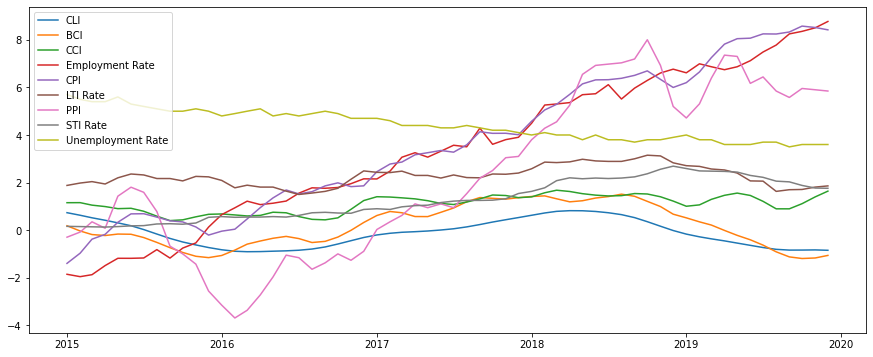

In [8]:
# Finally. Let's take a look at that stuff

# Trim to just Jan 2018 - Dec 2019
oecd2 = oecd[0:60]

plt.figure(figsize=(15, 6))
# plt.plot(oecd2['Employment Rate'])
plt.plot(oecd2)
plt.legend(oecd.columns, loc = 'upper left')
plt.show()

In [9]:
# Get our headline data 

#gTrends = pd.read_csv('Business Loan GTAB 2018-2019.csv')
# Back to GTrends data (not GTAB) with a bigger timeframe. But faked the GTAB process - divided by 13.6
gTrends = pd.read_csv('Business Loan GTrends 2016-19.csv')

gTrends = gTrends.loc[:,['date', 'business loan', 'isPartial']]

gTrends.rename(columns = {'business loan':'max_ratio'}, inplace = True)
#gTrends.head()

In [10]:
# Convert our week dates to the month
# First, make it a date, then change the DAY to be the 1st of the month 
gTrends['date'] = pd.to_datetime(gTrends['date'])
gTrends['Month'] = gTrends.apply(lambda x: x['date'].replace(day = 1), axis=1)

# Aggregation time! 
gTrends = gTrends.loc[:,['Month', 'max_ratio', 'isPartial']]

gTrends2 = gTrends.groupby('Month').agg({"max_ratio":  'mean'})

#gTrends2.head(20)

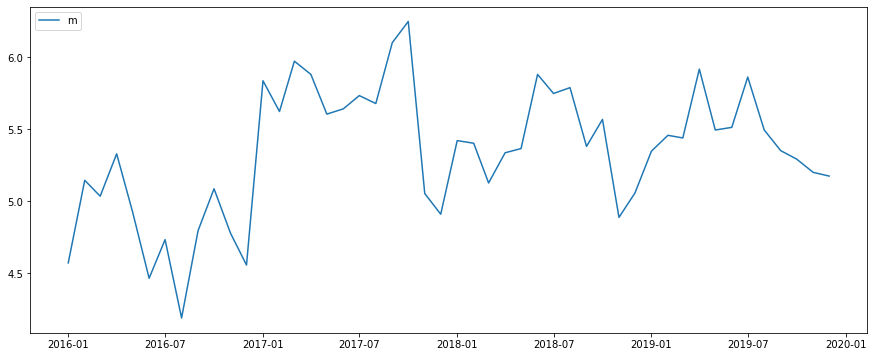

In [11]:
plt.figure(figsize=(15, 6))
# plt.plot(oecd2['Employment Rate'])
plt.plot(gTrends2['max_ratio'])
plt.legend('max_ratio', loc = 'upper left')
#ax = plt.gca()
#ax.set_xticklabels(labels=gTrends2.index,rotation=90);
plt.show()

In [12]:
# Let's start shifting time. If we want to use Jan 2020 to predict April 2020, a quick shortcut is to 
# just relabel Jan 2020 as April 2020 (for example). 
# Shifting the OECD data forward three months
#df.date + pd.DateOffset(months=
                        
# oecd2['TIME+3M'] = oecd2.apply(lambda x:  + pd.DateOffset(months = 3))
oecd2['TIME_ORIG'] = oecd2.index
oecd2['TIME+3M'] = oecd2.index +  pd.DateOffset(months = 3)
oecd2['TIME+6M'] = oecd2.index +  pd.DateOffset(months = 6)
oecd2['TIME+9M'] = oecd2.index +  pd.DateOffset(months = 9)
oecd2['TIME+12M'] = oecd2.index +  pd.DateOffset(months = 12)

oecd_3M = oecd2.set_index('TIME+3M')

In [13]:
oecd_6M = oecd2.set_index('TIME+6M')
oecd_9M = oecd2.set_index('TIME+9M')
oecd_12M = oecd2.set_index('TIME+12M')

In [14]:
# oecd2.reset_index(inplace = True)
oecd_12M.head()

,CLI,BCI,CCI,Employment Rate,CPI,LTI Rate,PPI,STI Rate,Unemployment Rate,TIME_ORIG,TIME+3M,TIME+6M,TIME+9M
TIME+12M,,,,,,,,,,,,,
2016-01-01,0.7341,0.18380,1.1536,-1.855,-1.39652,1.88,-0.29642,0.16,5.7,2015-01-01,2015-04-01,2015-07-01,2015-10-01
2016-02-01,0.6263,-0.03513,1.1561,-1.955,-0.96828,1.98,-0.08084,0.15,5.5,2015-02-01,2015-05-01,2015-08-01,2015-11-01
2016-03-01,0.5192,-0.18522,1.0509,-1.872,-0.37888,2.04,0.35030,0.14,5.4,2015-03-01,2015-06-01,2015-09-01,2015-12-01
2016-04-01,0.4155,-0.22597,0.9912,-1.489,-0.17636,1.94,0.08080,0.13,5.4,2015-04-01,2015-07-01,2015-10-01,2016-01-01
2016-05-01,0.3060,-0.16427,0.9036,-1.183,0.33250,2.20,1.42820,0.15,5.6,2015-05-01,2015-08-01,2015-11-01,2016-02-01


In [15]:
# Finally, let's merge that up and see what we can see 

# analysis = pd.join(gTrends2, oecd2, how = 'inner', left_on = 'Month', right_on = 'TIME')
# Safe to do since we're confident that we have the same indices and # of rows. 
analysis = gTrends2.join(oecd2)
analysis3M = gTrends2.join(oecd_3M)
analysis6M = gTrends2.join(oecd_6M)
analysis9M = gTrends2.join(oecd_9M)
analysis12M = gTrends2.join(oecd_12M)


In [16]:
analysis.head()
# len(analysis3M)

,max_ratio,CLI,BCI,CCI,Employment Rate,CPI,LTI Rate,PPI,STI Rate,Unemployment Rate,TIME_ORIG,TIME+3M,TIME+6M,TIME+9M,TIME+12M
Month,,,,,,,,,,,,,,,
2016-01-01,4.573529,-0.82484,-1.06475,0.6803,0.653,-0.04261,2.09,-3.15279,0.57,4.8,2016-01-01,2016-04-01,2016-07-01,2016-10-01,2017-01-01
2016-02-01,5.147059,-0.88707,-0.83865,0.6396,0.939,0.03970,1.78,-3.69173,0.54,4.9,2016-02-01,2016-05-01,2016-08-01,2016-11-01,2017-02-01
2016-03-01,5.036765,-0.90651,-0.58839,0.5962,1.218,0.47040,1.89,-3.36836,0.55,5.0,2016-03-01,2016-06-01,2016-09-01,2016-12-01,2017-03-01
2016-04-01,5.330882,-0.90119,-0.45601,0.6202,1.074,0.94680,1.81,-2.72164,0.55,5.1,2016-04-01,2016-07-01,2016-10-01,2017-01-01,2017-04-01
2016-05-01,4.926471,-0.88482,-0.34143,0.7536,1.132,1.35520,1.81,-1.96712,0.57,4.8,2016-05-01,2016-08-01,2016-11-01,2017-02-01,2017-05-01


In [17]:
# Correlation checks - anything here? 

# NO OFFSET 
corr, pval=stats.pearsonr(analysis['max_ratio'],analysis['CLI'])
print('CLI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis['max_ratio'],analysis['BCI'])
print('BCI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis['max_ratio'],analysis['CCI'])
print('CCI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis['max_ratio'],analysis['Employment Rate'])
print('Employment Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis['max_ratio'],analysis['CPI'])
print('CPI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis['max_ratio'],analysis['LTI Rate'])
print('LTI Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis['max_ratio'],analysis['PPI'])
print('PPI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis['max_ratio'],analysis['STI Rate'])
print('STI Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis['max_ratio'],analysis['Unemployment Rate'])
print('Unemployment Rate: Corr ', corr, " pval ", pval)


# CLI: Corr  0.39714743673158737  pval  0.005190693917874966
# BCI: Corr  0.4164539099279422  pval  0.003237288563279838
# CCI: Corr  0.5243091426672053  pval  0.00013074842109743508
# Employment Rate: Corr  0.3363662947745011  pval  0.019410515896186305
# CPI: Corr  0.3809688972140016  pval  0.007553000250831442
# LTI Rate: Corr  0.3690433286329835  pval  0.00984481733246452
# PPI: Corr  0.4182794729554248  pval  0.0030915123552858643
# STI Rate: Corr  0.3432536961203967  pval  0.01691664991773589
# Unemployment Rate: Corr  -0.4102509596000038  pval  0.003778853199690533

CLI: Corr  0.389836711410747  pval  0.0061633469172170515
BCI: Corr  0.4062753692925607  pval  0.004166419119599761
CCI: Corr  0.5415672123906439  pval  7.036797873330967e-05
Employment Rate: Corr  0.3489979126663344  pval  0.015049895933228218
CPI: Corr  0.39154927506427073  pval  0.0059222968044553214
LTI Rate: Corr  0.36589995960940747  pval  0.010540430851363506
PPI: Corr  0.4238277644050022  pval  0.002683351163535083
STI Rate: Corr  0.34458538396906063  pval  0.01646724594748941
Unemployment Rate: Corr  -0.419265161904001  pval  0.003015233507881721


In [18]:
# Correlation checks - anything here? 

# THREE MONTH OFFSET 
corr, pval=stats.pearsonr(analysis3M['max_ratio'],analysis3M['CLI'])
print('CLI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis3M['max_ratio'],analysis3M['BCI'])
print('BCI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis3M['max_ratio'],analysis3M['CCI'])
print('CCI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis3M['max_ratio'],analysis3M['Employment Rate'])
print('Employment Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis3M['max_ratio'],analysis3M['CPI'])
print('CPI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis3M['max_ratio'],analysis3M['LTI Rate'])
print('LTI Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis3M['max_ratio'],analysis3M['PPI'])
print('PPI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis3M['max_ratio'],analysis3M['STI Rate'])
print('STI Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis3M['max_ratio'],analysis3M['Unemployment Rate'])
print('Unemployment Rate: Corr ', corr, " pval ", pval)

# CLI: Corr  0.4054452797221113  pval  0.004251604418832922
# BCI: Corr  0.4032827910872637  pval  0.004480732463113991
# CCI: Corr  0.5315861799168602  pval  0.00010110194428673563
# Employment Rate: Corr  0.3434757518023329  pval  0.016840997943519263
# CPI: Corr  0.31950213350771894  pval  0.026856056680068373
# LTI Rate: Corr  0.47475460472423137  pval  0.000651051881033763
# PPI: Corr  0.33132715974874605  pval  0.021425975159958748
# STI Rate: Corr  0.362320371029731  pval  0.0113836586666051
# Unemployment Rate: Corr  -0.36925262981333357  pval  0.009799938214318356


CLI: Corr  0.3967953753476059  pval  0.005234258881671769
BCI: Corr  0.38971445623516626  pval  0.006180876835451148
CCI: Corr  0.5249478292294639  pval  0.00012786045970826553
Employment Rate: Corr  0.3560201401533808  pval  0.013008714291829386
CPI: Corr  0.33026601740678185  pval  0.02187211689555097
LTI Rate: Corr  0.46633404752283414  pval  0.0008354951013460544
PPI: Corr  0.3359420050465115  pval  0.019573800748599445
STI Rate: Corr  0.36650085233657514  pval  0.010404280831150537
Unemployment Rate: Corr  -0.3809894011743163  pval  0.0075494973373941635


In [19]:
# Correlation checks - anything here? 

# SIX MONTH OFFSET 
corr, pval=stats.pearsonr(analysis6M['max_ratio'],analysis6M['CLI'])
print('CLI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis6M['max_ratio'],analysis6M['BCI'])
print('BCI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis6M['max_ratio'],analysis6M['CCI'])
print('CCI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis6M['max_ratio'],analysis6M['Employment Rate'])
print('Employment Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis6M['max_ratio'],analysis6M['CPI'])
print('CPI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis6M['max_ratio'],analysis6M['LTI Rate'])
print('LTI Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis6M['max_ratio'],analysis6M['PPI'])
print('PPI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis6M['max_ratio'],analysis6M['STI Rate'])
print('STI Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis6M['max_ratio'],analysis6M['Unemployment Rate'])
print('Unemployment Rate: Corr ', corr, " pval ", pval)

# CLI: Corr  0.3043802761552124  pval  0.0354294561938273
# BCI: Corr  0.44124757482552524  pval  0.001693613802562371
# CCI: Corr  0.30763786327195686  pval  0.03341347831278653
# Employment Rate: Corr  0.3431252956193914  pval  0.01696052600961102
# CPI: Corr  0.3115895069617891  pval  0.03109628397964838
# LTI Rate: Corr  0.25285016557043993  pval  0.08293233407568427
# PPI: Corr  0.26268247623153507  pval  0.07126767594422181
# STI Rate: Corr  0.29033824487899673  pval  0.04530080731422346
# Unemployment Rate: Corr  -0.286704485328526  pval  0.04819098162527111


CLI: Corr  0.2957941697697997  pval  0.041228010692073616
BCI: Corr  0.43360963829346055  pval  0.002078431022556352
CCI: Corr  0.31292377507227825  pval  0.03034465832745013
Employment Rate: Corr  0.35380098158664625  pval  0.013626506160681754
CPI: Corr  0.32498542521133766  pval  0.02421015025482697
LTI Rate: Corr  0.24213036570925112  pval  0.09730043705449887
PPI: Corr  0.2715926901408158  pval  0.06185711568576554
STI Rate: Corr  0.2980989745386359  pval  0.03960007832775946
Unemployment Rate: Corr  -0.29682146392446696  pval  0.04049576714598735


In [20]:
# Correlation checks - anything here? 

# NINE MONTH OFFSET 
corr, pval=stats.pearsonr(analysis9M['max_ratio'],analysis9M['CLI'])
print('CLI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis9M['max_ratio'],analysis9M['BCI'])
print('BCI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis9M['max_ratio'],analysis9M['CCI'])
print('CCI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis9M['max_ratio'],analysis9M['Employment Rate'])
print('Employment Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis9M['max_ratio'],analysis9M['CPI'])
print('CPI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis9M['max_ratio'],analysis9M['LTI Rate'])
print('LTI Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis9M['max_ratio'],analysis9M['PPI'])
print('PPI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis9M['max_ratio'],analysis9M['STI Rate'])
print('STI Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis9M['max_ratio'],analysis9M['Unemployment Rate'])
print('Unemployment Rate: Corr ', corr, " pval ", pval)

# CLI: Corr  0.10240816303687715  pval  0.4885439361542668
# BCI: Corr  0.4119436950231195  pval  0.0036236932838207866
# CCI: Corr  0.2992704215117418  pval  0.03879310333026953
# Employment Rate: Corr  0.35094764199080114  pval  0.014457524386868835
# CPI: Corr  0.33365635669754445  pval  0.0204735054385207
# LTI Rate: Corr  0.047419748168014024  pval  0.7489276144809552
# PPI: Corr  0.20326259580537293  pval  0.16585760308736539
# STI Rate: Corr  0.2571690697960508  pval  0.07763676302640493
# Unemployment Rate: Corr  -0.2937432813120011  pval  0.04272230007019789


CLI: Corr  0.0945721947439161  pval  0.5225760226469843
BCI: Corr  0.41007038667068535  pval  0.0037957444918661747
CCI: Corr  0.3014714425957806  pval  0.037313420464746096
Employment Rate: Corr  0.3624286391854563  pval  0.011357330073349076
CPI: Corr  0.3465123540676751  pval  0.015834925882331385
LTI Rate: Corr  0.045256445343081854  pval  0.7600330391485082
PPI: Corr  0.2113479095090873  pval  0.14929946612680345
STI Rate: Corr  0.2682378839081111  pval  0.0652761595770315
Unemployment Rate: Corr  -0.30194894235150704  pval  0.03699862182595651


In [21]:
# Correlation checks - anything here? 

# TWELVE MONTH OFFSET 
corr, pval=stats.pearsonr(analysis12M['max_ratio'],analysis12M['CLI'])
print('CLI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis12M['max_ratio'],analysis12M['BCI'])
print('BCI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis12M['max_ratio'],analysis12M['CCI'])
print('CCI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis12M['max_ratio'],analysis12M['Employment Rate'])
print('Employment Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis12M['max_ratio'],analysis12M['CPI'])
print('CPI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis12M['max_ratio'],analysis12M['LTI Rate'])
print('LTI Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis12M['max_ratio'],analysis12M['PPI'])
print('PPI: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis12M['max_ratio'],analysis12M['STI Rate'])
print('STI Rate: Corr ', corr, " pval ", pval)

corr, pval=stats.pearsonr(analysis12M['max_ratio'],analysis12M['Unemployment Rate'])
print('Unemployment Rate: Corr ', corr, " pval ", pval)

# CLI: Corr  -0.1728093117406397  pval  0.24017058955531392
# BCI: Corr  0.17768456001620814  pval  0.2269597780151463
# CCI: Corr  0.022226639721387886  pval  0.8808040925983736
# Employment Rate: Corr  0.38846250539884575  pval  0.006362904173684194
# CPI: Corr  0.2951407486953085  pval  0.04169937811884678
# LTI Rate: Corr  -0.13939993974861203  pval  0.34468041734754
# PPI: Corr  -0.019105526002919277  pval  0.8974450908282187
# STI Rate: Corr  0.27609538760675056  pval  0.05749507961727958
# Unemployment Rate: Corr  -0.30697331163037  pval  0.03381684734777973


CLI: Corr  -0.178418397085351  pval  0.22501551865318672
BCI: Corr  0.176230852940332  pval  0.23084541841939094
CCI: Corr  0.02232691581748209  pval  0.8802702494857692
Employment Rate: Corr  0.4021014622359774  pval  0.004610412254424519
CPI: Corr  0.3034227627958149  pval  0.03604074555873418
LTI Rate: Corr  -0.135283811221089  pval  0.3592517599478718
PPI: Corr  -0.015270948221757404  pval  0.9179492376953516
STI Rate: Corr  0.29289651531911876  pval  0.04335203561968666
Unemployment Rate: Corr  -0.31589596898599914  pval  0.02872448211694548


In [22]:
analysis.to_csv('GBC train 0M.csv')
analysis3M.to_csv('GBC train 03M.csv')
analysis6M.to_csv('GBC train 06M.csv')
analysis9M.to_csv('GBC train 09M.csv')
analysis12M.to_csv('GBC train 12M.csv')